# Classify Yelp Reviews 1-5 stars

## Baseline Model

In [4]:
%%capture
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install torch
!pip install scikit-learn

In [5]:
import numpy as np
import evaluate
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd

In [3]:
# 1. Load in the data
dataset = load_dataset("yelp_review_full")

Found cached dataset yelp_review_full (/Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# %%capture

# 2. down-sample the dataset so it takes less time to train a quick baseline  model
dataset_small = dataset["train"].train_test_split(train_size=100, test_size=20, seed=42, stratify_by_column="label")

# 3. Load the tokenizer and define the tokenization function
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# 4. Tokenize our training and test data
tokenized_datasets = dataset_small.map(tokenize_function, batched=True)

# 5. Load in the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# 6. Define an evaluation metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 7. Set up the Trainer
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=1)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# 8. Train the model
trainer.train()

Found cached dataset yelp_review_full (/Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached split indices for dataset at /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-2403bacf86757b14.arrow and /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-b05e24212690dea3.arrow
Loading cached processed dataset at /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-7df40f0f950cde94.arrow
Loading cached processed dataset at /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-9e189bd0c6edb59c.arrow
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.6163889169692993, 'eval_accuracy': 0.3, 'eval_runtime': 1.5651, 'eval_samples_per_second': 12.779, 'eval_steps_per_second': 1.917, 'epoch': 1.0}
{'train_runtime': 31.0158, 'train_samples_per_second': 3.224, 'train_steps_per_second': 0.419, 'train_loss': 1.6369115389310396, 'epoch': 1.0}


TrainOutput(global_step=13, training_loss=1.6369115389310396, metrics={'train_runtime': 31.0158, 'train_samples_per_second': 3.224, 'train_steps_per_second': 0.419, 'train_loss': 1.6369115389310396, 'epoch': 1.0})

In [4]:
model.to('cpu')

def predict(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return predicted_class_id

review_5stars = "This is a great restaurant!"
review_4stars = "This was overall a good experience, above average restaurant"
review_3stars = "This was an alright restaurant"
review_2stars = "This is a pretty bad restaurant. I might try again but I was disappointed"
review_1stars = "This is a terrible restaurant!"

reviews = [review_5stars, review_4stars, review_3stars, review_2stars, review_1stars]

for review in reviews:
    print(f"Model predicted {predict(review)+1} stars for review: {review}")

Model predicted 5 stars for review: This is a great restaurant!
Model predicted 5 stars for review: This was overall a good experience, above average restaurant
Model predicted 5 stars for review: This was an alright restaurant
Model predicted 5 stars for review: This is a pretty bad restaurant. I might try again but I was disappointed
Model predicted 5 stars for review: This is a terrible restaurant!


# Don't run this!! But see that simply adding more data, same code, the accuracy improves

In [18]:
# %%capture

# 1. Load in the data
dataset = load_from_disk("data/yelp_review_small/")

# 2. Load the tokenizer and define the tokenization function
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# 3. Tokenize our training and test data
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 4. Load in the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# 5. Define an evaluation metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 6. Set up the Trainer
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# 7. Train the model
trainer.train()

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

/Users/d/miniforge3/envs/bert/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.0930134057998657, 'eval_accuracy': 0.525, 'eval_runtime': 15.3889, 'eval_samples_per_second': 12.996, 'eval_steps_per_second': 1.625, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.0063376426696777, 'eval_accuracy': 0.58, 'eval_runtime': 15.3839, 'eval_samples_per_second': 13.001, 'eval_steps_per_second': 1.625, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.015762448310852, 'eval_accuracy': 0.595, 'eval_runtime': 15.3847, 'eval_samples_per_second': 13.0, 'eval_steps_per_second': 1.625, 'epoch': 3.0}
{'train_runtime': 745.9547, 'train_samples_per_second': 3.217, 'train_steps_per_second': 0.402, 'train_loss': 0.9802055867513021, 'epoch': 3.0}


TrainOutput(global_step=300, training_loss=0.9802055867513021, metrics={'train_runtime': 745.9547, 'train_samples_per_second': 3.217, 'train_steps_per_second': 0.402, 'train_loss': 0.9802055867513021, 'epoch': 3.0})

In [42]:
model.to('cpu')

def predict(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return predicted_class_id

review_5stars = "This is a great restaurant!"
review_4stars = "This was overall a good experience, above average restaurant"
review_3stars = "This was an alright restaurant"
review_2stars = "This is a pretty bad restaurant. I might try again but I was disappointed"
review_1stars = "This is a terrible restaurant!"

reviews = [review_5stars, review_4stars, review_3stars, review_2stars, review_1stars]

for review in reviews:
    print(f"Model predicted class {predict(review)} for review: {review}")

Model predicted class 4 for review: This is a great restaurant!
Model predicted class 3 for review: This was overall a good experience, above average restaurant
Model predicted class 2 for review: This was an alright restaurant
Model predicted class 1 for review: This is a pretty bad restaurant. I might try again but I was disappointed
Model predicted class 0 for review: This is a terrible restaurant!


# Review the dataset

In [13]:
# Convert to pandas dataframe
df = dataset['train'].to_pandas()

In [14]:
df_1star = df[df['label'] == 0]
sample = df_1star['text'].values[-1]
sample.split(".")[:5]

['I have been using this company for 11 months',
 '  Ryan would come out every other week and do what he needed to be done',
 ' Very little was required as I have desert landscaping and pretty much maintained it myself',
 '  Just needed blowing and general light cleanup',
 '  Ryan was very thorough']

In [15]:
sample.split(".")[-5:]

['',
 '',
 'NOT EVEN A CALL WHEN THEY CANNOT COME',
 '   \\n\\nSORRY RYAN, I WILL TAKE MY BUSINESS ELSEWHERE',
 '  AS A BUSINESS OWNER, YOU SHOULD KNOW BETTER!!!!']

# Evaluate if default token length of 512 is appropriate for this dataset

In [7]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") # uncased means lowercase

def tokenize_function(examples):
    """this time we won't truncate the examples so that we can evaluate the distribution of the number of tokens for our reviews
    """
    # prior implementation we used for training: return tokenizer(examples["text"], padding="max_length", truncation=True)
    return tokenizer(examples["text"])

# this time we are doing the full dataset!
tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_df = pd.DataFrame(tokenized_datasets["train"])
train_df["input_ids"].apply(len).describe()

Loading cached processed dataset at /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-df99a9b687c288ec.arrow
Loading cached processed dataset at /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-0b490f4e793ed0b0.arrow


count    650000.000000
mean        180.696091
std         163.847267
min           3.000000
25%          71.000000
50%         132.000000
75%         236.000000
max        2344.000000
Name: input_ids, dtype: float64

<Axes: >

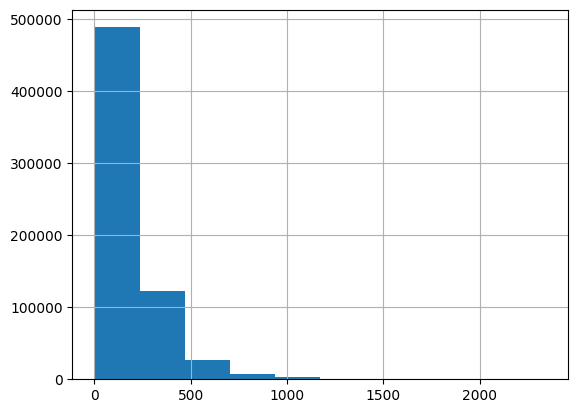

In [8]:
train_df["input_ids"].apply(len).hist()

In [9]:
train_df["input_ids_token_length"] = train_df["input_ids"].apply(len)

In [10]:
train_df[train_df["input_ids_token_length"] > 512].sort_values(by="input_ids_token_length", ascending=False).head()

,label,text,input_ids,attention_mask,input_ids_token_length
614419,3,"Pour le jour de l'an 2010, nous \u00e9tions a ...","[101, 10364, 3393, 8183, 3126, 2139, 1048, 100...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2344
546323,4,**Summary**\n - Best - I have to start b...,"[101, 1008, 1008, 12654, 1008, 1008, 1032, 105...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2045
466919,2,"Torii @ Lavel, Quecec, Canada, \u30ab\u30ca\u3...","[101, 23413, 2072, 1030, 2474, 15985, 1010, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1966
570102,4,"WED, MARCH 27, 2013 // 12:00PM-2:00PM \n ...","[101, 21981, 1010, 2233, 2676, 1010, 2286, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1903
603624,1,"Was hier rumsitzt kennt das Angebot, diese bun...","[101, 2001, 7632, 2121, 19379, 28032, 2480, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1896


In [11]:
train_df[train_df["input_ids_token_length"] > 512].shape[0] / train_df.shape[0]

0.04655846153846154

#### Observation:  
 
 Less than 5% of the reviews are longer than 512 tokens (which is the maximum length of the input for the DistilBERT model) meaning they will be truncated and we will lose information. This isn't ideal because we want to be able to classify the sentiment of the entire review, not just the first 512 tokens. 

For our use case, it seems reasonable (intuitively) that our model can assess the sentiment of a review based on the first 512 tokens. This analysis is still useful as it gives us a quantitative measure of our information loss by using Distilbert.

# Try to make it better

In [13]:
# 2. down-sample the dataset so it takes less time to train a quick baseline  model
dataset_small = dataset["train"].train_test_split(train_size=100, test_size=20, seed=42, stratify_by_column="label")

# 3. Load the tokenizer and define the tokenization function
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# 4. Tokenize our training and test data
tokenized_datasets = dataset_small.map(tokenize_function, batched=True)

# 5. Load in the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=5)

# 6. Define an evaluation metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 7. Set up the Trainer
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=3)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# 8. Train the model
trainer.train()

Loading cached split indices for dataset at /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-2403bacf86757b14.arrow and /Users/d/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-b05e24212690dea3.arrow


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.w

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.6207237243652344, 'eval_accuracy': 0.25, 'eval_runtime': 1.6253, 'eval_samples_per_second': 12.305, 'eval_steps_per_second': 1.846, 'epoch': 1.0}
{'train_runtime': 32.7459, 'train_samples_per_second': 3.054, 'train_steps_per_second': 0.397, 'train_loss': 1.6440379802997296, 'epoch': 1.0}


TrainOutput(global_step=13, training_loss=1.6440379802997296, metrics={'train_runtime': 32.7459, 'train_samples_per_second': 3.054, 'train_steps_per_second': 0.397, 'train_loss': 1.6440379802997296, 'epoch': 1.0})

In [14]:
model.to('cpu')

def predict(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return predicted_class_id

review_5stars = "This is a great restaurant!"
review_4stars = "This was overall a good experience, above average restaurant"
review_3stars = "This was an alright restaurant"
review_2stars = "This is a pretty bad restaurant. I might try again but I was disappointed"
review_1stars = "This is a terrible restaurant!"

reviews = [review_5stars, review_4stars, review_3stars, review_2stars, review_1stars]

for review in reviews:
    print(f"Model predicted {predict(review)+1} stars for review: {review}")

Model predicted 5 stars for review: This is a great restaurant!
Model predicted 5 stars for review: This was overall a good experience, above average restaurant
Model predicted 1 stars for review: This was an alright restaurant
Model predicted 1 stars for review: This is a pretty bad restaurant. I might try again but I was disappointed
Model predicted 5 stars for review: This is a terrible restaurant!


In [15]:
mcdonalds_chatgpt_review = "There once was a man with low standards, For McDonald's, he had few demands, But this one store Failed him once more, In a way that was truly grand. The cashier took his friend's order, But ignored him, the selfish border, He waited and waited, Became frustrated, And his patience began to falter. He watched as others were served first, His stomach was starting to thirst, He asked for his meal, The manager did deal, But was rude and left him averse. This man had eaten at McDonald's, For over thirty years, he's no fraud, But this store's service, Had made him nervous, To return, he thought it was odd. He'd rather go to Steak n Shake, Despite their racial mistakes, For at least there he knew, They'd serve him, it's true, And not leave him with a stomach ache."

predict(review)+1

5